Modelling with Corr n = 35

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [4]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Flow ID                      360000 non-null  object 
 2   Source IP                    360000 non-null  object 
 3   Source Port                  360000 non-null  int64  
 4   Destination IP               360000 non-null  object 
 5   Destination Port             360000 non-null  int64  
 6   Protocol                     360000 non-null  int64  
 7   Timestamp                    360000 non-null  object 
 8   Flow Duration                360000 non-null  int64  
 9   Total Fwd Packets            360000 non-null  int64  
 10  Total Backward Packets       360000 non-null  int64  
 11  Total Length of Fwd Packets  360000 non-null  float64
 12  Total Length of Bwd Packets  360000 non-null  float64
 13 

In [5]:
#Bagian awal dataset
df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,28102,172.16.0.5-192.168.50.1-553-11930-17,172.16.0.5,553,192.168.50.1,11930,17,2018-12-01 11:23:04.133911,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
1,17675,172.16.0.5-192.168.50.1-997-4051-17,172.16.0.5,997,192.168.50.1,4051,17,2018-12-01 11:32:18.205323,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
2,661545,172.16.0.5-192.168.50.1-27238-3411-6,172.16.0.5,27238,192.168.50.1,3411,6,2018-12-01 13:31:10.155752,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
3,688385,172.16.0.5-192.168.50.1-36181-39435-6,172.16.0.5,36181,192.168.50.1,39435,6,2018-12-01 13:30:48.279274,51,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
4,16016,172.16.0.5-192.168.50.1-35261-14404-17,172.16.0.5,35261,192.168.50.1,14404,17,2018-12-01 13:02:49.155721,105961,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


In [6]:
df.describe()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,360000.000000,360000.000000,3.600000e+05,3.600000e+05,360000.000000,...,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000
mean,91493.758128,26078.477756,30912.601833,14.700269,2.200160e+06,8.975250,0.585044,3.733058e+03,3.847677e+02,582.758328,...,-3.609785e+07,7.325171e+03,2.620700e+03,1.084865e+04,5.733338e+03,6.801519e+05,1.105356e+05,8.047233e+05,5.820746e+05,0.930525
std,135889.709116,25364.107740,20110.524442,4.502866,1.275317e+07,250.280517,12.328315,3.287519e+04,3.131816e+04,544.547707,...,1.925211e+08,1.685573e+05,7.402011e+04,2.224704e+05,1.570655e+05,4.457633e+06,1.025535e+06,5.103451e+06,4.112389e+06,0.254261
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,11986.000000,771.000000,13028.000000,17.000000,1.000000e+00,2.000000,0.000000,4.580000e+02,0.000000e+00,229.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,38063.500000,21346.500000,30909.000000,17.000000,2.000000e+00,2.000000,0.000000,1.088000e+03,0.000000e+00,415.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,106306.000000,52107.250000,48665.000000,17.000000,1.821250e+03,4.000000,0.000000,2.944000e+03,0.000000e+00,1035.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,805151.000000,65534.000000,65535.000000,17.000000,1.200000e+08,86220.000000,4602.000000,1.526642e+07,8.818824e+06,32120.000000,...,1.480000e+03,1.721058e+07,2.284064e+07,4.358468e+07,1.310114e+07,1.058368e+08,6.600292e+07,1.058368e+08,1.058368e+08,1.000000


In [7]:
df['Label'].value_counts()

Label
DrDoS_LDAP       30000
Syn              30000
DrDoS_UDP        30000
DrDoS_NetBIOS    30000
DrDoS_MSSQL      30000
DrDoS_DNS        30000
DrDoS_SSDP       30000
DrDoS_SNMP       30000
DrDoS_NTP        30000
TFTP             30000
UDP-lag          30000
BENIGN           30000
Name: count, dtype: int64

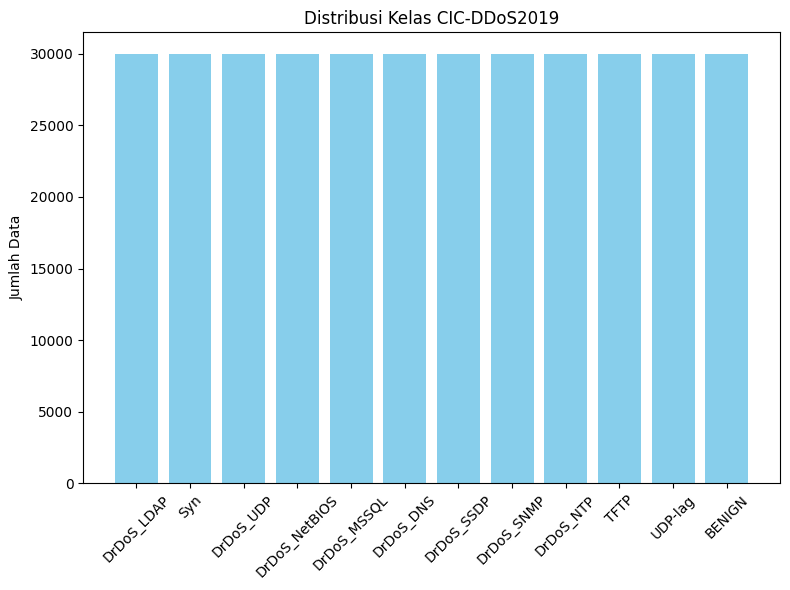

In [8]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Kelas CIC-DDoS2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

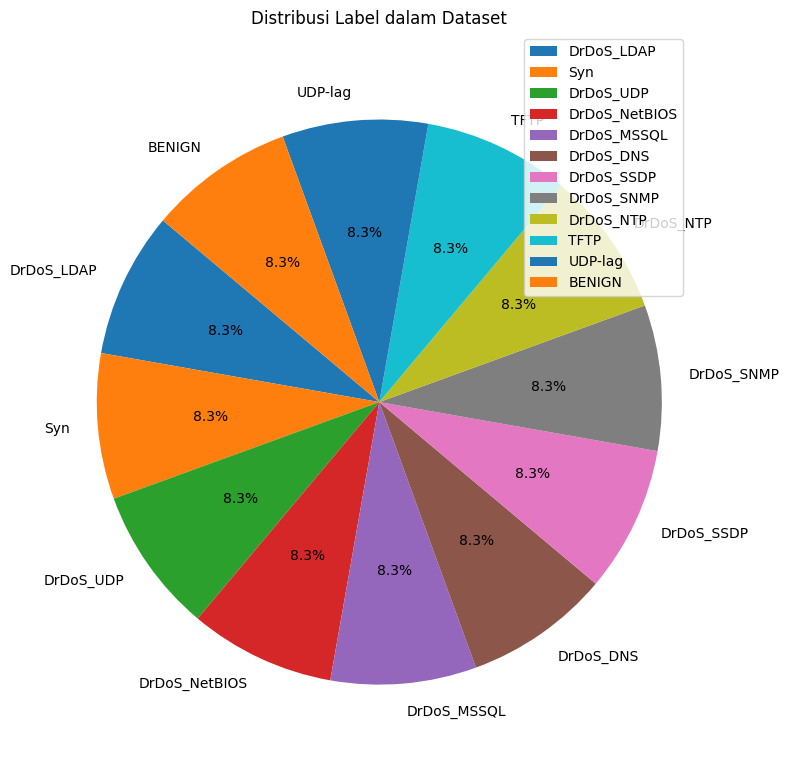

In [9]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [10]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [11]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [12]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [13]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

,Label
0,2
1,2
2,9
3,9
4,8


### X dan Y

In [14]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Feature Selection Pearson Corr

#### StandarScaler

In [16]:
categorical_features = ['Protocol', 'Inbound']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [17]:
# Copy data asli untuk jaga-jaga
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [18]:
# Standarisasi fitur numerik saja
scaler = StandardScaler()

# Standarisasi hanya fitur numerik, simpan hasil ke variabel baru
X_train_scaled = X_train_copy.copy()
X_test_scaled = X_test_copy.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_copy[numerical_features])

In [19]:
# Opsional: Kalau mau konversi ke array, tinggal pakai
X_train_scaled_array = X_train_scaled.to_numpy()
X_test_scaled_array = X_test_scaled.to_numpy()

In [20]:
X_train_scaled.head()

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
203490,-0.609988,17,-0.170116,-0.024477,0.106137,-0.095914,-0.004140,-1.008412,-0.971828,-1.001306,...,0.187819,-0.043687,-0.039671,-0.050299,-0.035945,-0.151366,-0.106952,-0.156516,-0.140247,0
221637,-0.420847,17,-0.171764,-0.024477,-0.044647,-0.021320,-0.011938,1.627672,1.676395,1.674034,...,0.187827,-0.043687,-0.039671,-0.050299,-0.035945,-0.151366,-0.106952,-0.156516,-0.140247,1
32895,1.406980,6,3.254406,-0.011084,-0.044647,-0.097572,-0.011938,-1.066992,-1.030678,-1.060758,...,0.187819,-0.043534,-0.039172,-0.050072,-0.035938,4.742563,4.697120,4.803544,4.310472,1
50702,-0.174804,17,-0.163154,-0.017781,-0.044647,-0.060327,-0.011938,-0.354883,-0.423793,-0.392852,...,0.187819,-0.043687,-0.039671,-0.050299,-0.035945,-0.151366,-0.106952,-0.156516,-0.140247,1
191147,-0.445925,17,0.064468,-0.017781,-0.044647,-0.044113,-0.011938,-0.122395,-0.081731,-0.102095,...,0.187819,-0.043687,-0.039671,-0.050299,-0.035945,-0.151366,-0.106952,-0.156516,-0.140247,1


#### Corr

In [21]:
# Tampilkan semua baris DataFrame
pd.set_option('display.max_rows', None)

In [22]:
# Hitung korelasi absolut antara setiap fitur dan label
correlations = []

for col in X_train_scaled.columns:
    if X_train_scaled[col].nunique() > 1:  # pastikan fitur tidak konstan
        corr = np.corrcoef(X_train_scaled[col], y_train)[0, 1]
        correlations.append((col, abs(corr)))
    else:
        correlations.append((col, 0))  # fitur konstan → korelasi 0

# Buat DataFrame hasil korelasi
correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Tampilkan hasil
print("📊 Korelasi absolut antara fitur dan label (berdasarkan data latih):")
print(correlation_df)

📊 Korelasi absolut antara fitur dan label (berdasarkan data latih):
                        Feature  Correlation
0                ACK Flag Count     0.467075
1                       Inbound     0.430089
2                    Unnamed: 0     0.424356
3             Max Packet Length     0.417998
4         Fwd Packet Length Max     0.411718
5            Packet Length Mean     0.405415
6           Average Packet Size     0.404202
7                  Flow Bytes/s     0.403694
8          Avg Fwd Segment Size     0.396215
9        Fwd Packet Length Mean     0.396215
10        Fwd Packet Length Min     0.384053
11            Min Packet Length     0.383983
12               URG Flag Count     0.304255
13                     Protocol     0.275093
14                Down/Up Ratio     0.262968
15        Bwd Packet Length Min     0.237501
16                Flow IAT Mean     0.210250
17               CWE Flag Count     0.202537
18                 Fwd IAT Mean     0.195631
19         Avg Bwd Segment Size 

In [26]:
# Ambil 55 fitur terbaik berdasarkan korelasi absolut
selected_features = correlation_df.head(55)['Feature'].tolist()

# (Opsional) Tampilkan dimensi atau nama fitur terpilih
print(f"Jumlah fitur terpilih: {len(selected_features)}")
print("Fitur-fitur terpilih:")
print(selected_features)

Jumlah fitur terpilih: 55
Fitur-fitur terpilih:
['ACK Flag Count', 'Inbound', 'Unnamed: 0', 'Max Packet Length', 'Fwd Packet Length Max', 'Packet Length Mean', 'Average Packet Size', 'Flow Bytes/s', 'Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Min Packet Length', 'URG Flag Count', 'Protocol', 'Down/Up Ratio', 'Bwd Packet Length Min', 'Flow IAT Mean', 'CWE Flag Count', 'Fwd IAT Mean', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Flow IAT Std', 'Fwd PSH Flags', 'RST Flag Count', 'Fwd IAT Std', 'Packet Length Std', 'Init_Win_bytes_backward', 'Bwd Packet Length Std', 'Bwd Packet Length Max', 'Fwd Packet Length Std', 'Bwd IAT Total', 'Idle Std', 'act_data_pkt_fwd', 'Fwd IAT Max', 'Bwd IAT Max', 'Flow IAT Max', 'Total Backward Packets', 'Subflow Bwd Packets', 'Active Mean', 'Active Max', 'Packet Length Variance', 'Bwd IAT Min', 'Active Min', 'Fwd IAT Total', 'Idle Max', 'Bwd IAT Std', 'Flow Duration', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'm

In [27]:
# Buat DataFrame dengan hanya 55 fitur teratas dari data latih
X_train_selected_scaled_df = X_train_scaled[selected_features]
X_test_selected_scaled_df = X_test_scaled[selected_features]

In [37]:
X_train_selected_scaled = X_train_selected_scaled_df.to_numpy()
X_test_selected_scaled = X_test_selected_scaled_df.to_numpy()

In [40]:
X_test_selected_scaled

array([[-0.45153193,  1.        , -0.24282183, ..., -0.03967127,
        -0.0664178 , -0.01962317],
       [-0.45153193,  1.        ,  0.24146577, ..., -0.03967127,
        -0.0664178 , -0.01962317],
       [ 2.2146828 ,  0.        , -0.63685356, ...,  0.66611382,
         5.49933174, -0.01962317],
       ...,
       [-0.45153193,  1.        , -0.45591514, ..., -0.03967127,
        -0.0664178 , -0.01962317],
       [-0.45153193,  1.        , -0.25304725, ..., -0.03967127,
        -0.0664178 , -0.01962317],
       [-0.45153193,  1.        , -0.39273824, ..., -0.03967127,
        -0.0664178 , -0.01962317]])

In [29]:
X_train_selected_scaled_df.head()

,ACK Flag Count,Inbound,Unnamed: 0,Max Packet Length,Fwd Packet Length Max,Packet Length Mean,Average Packet Size,Flow Bytes/s,Avg Fwd Segment Size,Fwd Packet Length Mean,...,Bwd IAT Std,Flow Duration,Total Length of Fwd Packets,Subflow Fwd Bytes,min_seg_size_forward,Idle Mean,Bwd Header Length,Active Std,Bwd IAT Mean,SYN Flag Count
203490,-0.451532,0,-0.609988,-0.782813,-1.008412,-0.936218,-0.904114,-0.736452,-1.001306,-1.001306,...,-0.074129,-0.170116,-0.095914,-0.095914,0.187819,-0.151366,0.018152,-0.039671,-0.066414,-0.019623
221637,-0.451532,1,-0.420847,1.446704,1.627672,1.673345,1.691046,0.770428,1.674034,1.674034,...,-0.074129,-0.171764,-0.021320,-0.021320,0.187827,-0.151366,0.018151,-0.039671,-0.066418,-0.019623
32895,2.214683,1,1.406980,-0.995148,-1.066992,-1.067292,-1.011837,-0.736468,-1.060758,-1.060758,...,-0.074129,3.254406,-0.097572,-0.097572,0.187819,4.742563,0.018151,-0.039172,-0.066418,-0.019623
50702,-0.451532,1,-0.174804,-0.349849,-0.354883,-0.408943,-0.470771,-0.736454,-0.392852,-0.392852,...,-0.074129,-0.163154,-0.060327,-0.060327,0.187819,-0.151366,0.018151,-0.039671,-0.066418,-0.019623
191147,-0.451532,1,-0.445925,-0.139173,-0.122395,-0.106579,-0.222272,-0.736467,-0.102095,-0.102095,...,-0.074129,0.064468,-0.044113,-0.044113,0.187819,-0.151366,0.018151,-0.039671,-0.066418,-0.019623


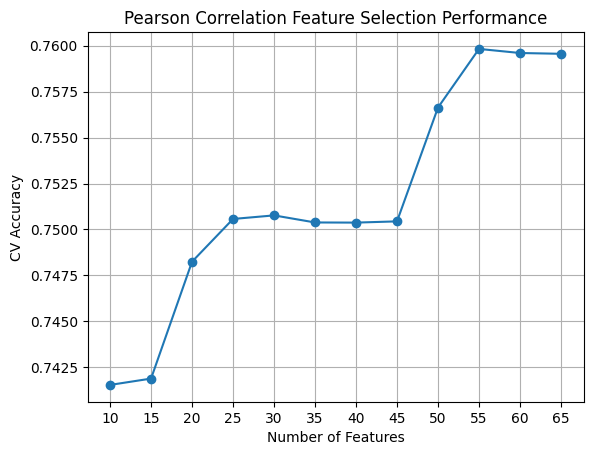

In [27]:
# Custom function to compute absolute Pearson correlation as feature scores
def pearson_score(X, y):
    scores = []
    for i in range(X.shape[1]):
        if np.std(X[:, i]) == 0:
            scores.append(0)
        else:
            corr = np.corrcoef(X[:, i], y)[0, 1]
            scores.append(abs(corr))
    return np.array(scores), np.array([0] * X.shape[1])  # kedua elemen dikembalikan sesuai format yang diminta oleh SelectKBest

scores_pc = []
k_range = range(10, 70, 5)

for k in k_range:
    model = Pipeline([
        ('select', SelectKBest(score_func=pearson_score, k=k)),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True)
    mean_test_score = results['test_score'].mean()
    scores_pc.append(mean_test_score)

# Plot hasil
plt.plot(k_range, scores_pc, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV Accuracy")
plt.title("Pearson Correlation Feature Selection Performance")
plt.grid(True)
plt.xticks(k_range) 
plt.show()

In [32]:
# 6. Filter dataset untuk fitur yang lolos seleksi
X_train_selected_scaled_df = X_train_scaled[selected_features]
X_test_selected_scaled_df = X_test_scaled[selected_features]


In [48]:
# Opsional: Kalau mau konversi ke array, tinggal pakai
X_train_selected_scaled = X_train_selected_scaled_df.to_numpy()
X_test_selected_scaled = X_test_selected_scaled_df.to_numpy()

In [ ]:
# Gunakan indexing array berdasarkan indeks numerik
X_train_selected_scaled = X_train_scaled[:, selected_indices]
X_test_selected_scaled = X_test_scaled[:, selected_indices]

### Modeling with Feature Selection

In [30]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

#### Ensemble Learning

#### Algoritma Individual

##### DT

Waktu pelatihan (Decision Tree): 2.9634 detik
Waktu prediksi (Decision Tree): 0.0393 detik


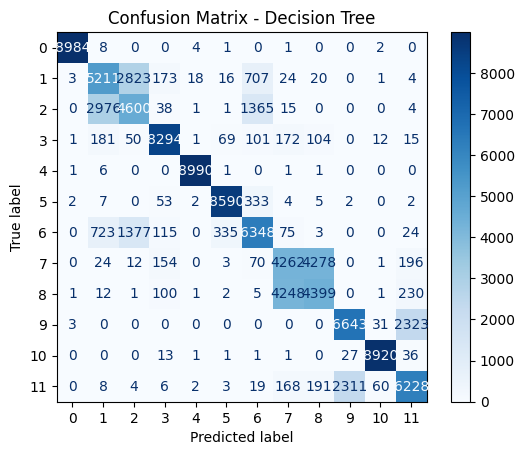

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.57      0.58      0.57      9000
           2       0.52      0.51      0.51      9000
           3       0.93      0.92      0.92      9000
           4       1.00      1.00      1.00      9000
           5       0.95      0.95      0.95      9000
           6       0.71      0.71      0.71      9000
           7       0.48      0.47      0.47      9000
           8       0.49      0.49      0.49      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.69      0.69      9000

    accuracy                           0.75    108000
   macro avg       0.75      0.75      0.75    108000
weighted avg       0.75      0.75      0.75    108000



In [41]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_selected_scaled, y_test, name="Decision Tree")

##### LR

Waktu pelatihan (Logistic Regression): 389.4853 detik
Waktu prediksi (Logistic Regression): 0.0184 detik


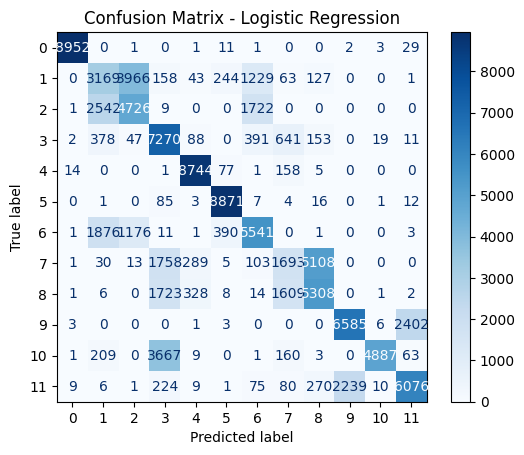

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9000
           1       0.39      0.35      0.37      9000
           2       0.48      0.53      0.50      9000
           3       0.49      0.81      0.61      9000
           4       0.92      0.97      0.94      9000
           5       0.92      0.99      0.95      9000
           6       0.61      0.62      0.61      9000
           7       0.38      0.19      0.25      9000
           8       0.48      0.59      0.53      9000
           9       0.75      0.73      0.74      9000
          10       0.99      0.54      0.70      9000
          11       0.71      0.68      0.69      9000

    accuracy                           0.67    108000
   macro avg       0.68      0.67      0.66    108000
weighted avg       0.68      0.67      0.66    108000



In [42]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_selected_scaled, y_test, name="Logistic Regression")

##### AdaBoost

Waktu pelatihan (AdaBoost): 14.3734 detik
Waktu prediksi (AdaBoost Classifier): 0.9486 detik


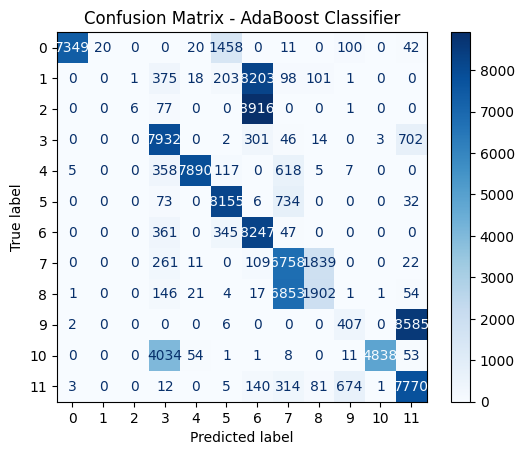

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      9000
           1       0.00      0.00      0.00      9000
           2       0.86      0.00      0.00      9000
           3       0.58      0.88      0.70      9000
           4       0.98      0.88      0.93      9000
           5       0.79      0.91      0.85      9000
           6       0.32      0.92      0.47      9000
           7       0.44      0.75      0.55      9000
           8       0.48      0.21      0.29      9000
           9       0.34      0.05      0.08      9000
          10       1.00      0.54      0.70      9000
          11       0.45      0.86      0.59      9000

    accuracy                           0.57    108000
   macro avg       0.60      0.57      0.51    108000
weighted avg       0.60      0.57      0.51    108000



In [43]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test_selected_scaled, y_test, name="AdaBoost Classifier")

##### KNN

Waktu pelatihan (KNN): 0.0410 detik
Waktu prediksi (KNN): 21.6160 detik


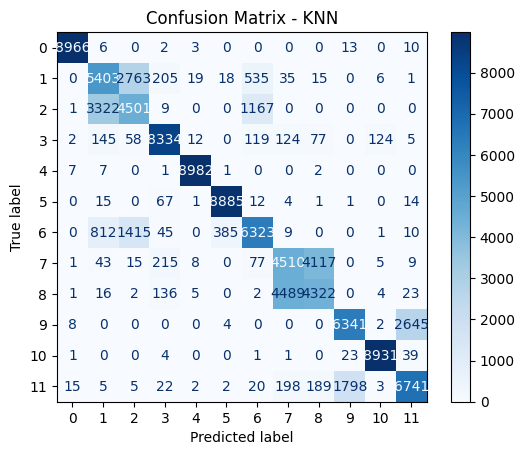

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.60      0.58      9000
           2       0.51      0.50      0.51      9000
           3       0.92      0.93      0.92      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.77      0.70      0.73      9000
           7       0.48      0.50      0.49      9000
           8       0.50      0.48      0.49      9000
           9       0.78      0.70      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.71      0.75      0.73      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [44]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_selected_scaled, y_test, name="KNN")

Waktu pelatihan (KNN): 0.0481 detik
Waktu prediksi (KNN): 21.5428 detik


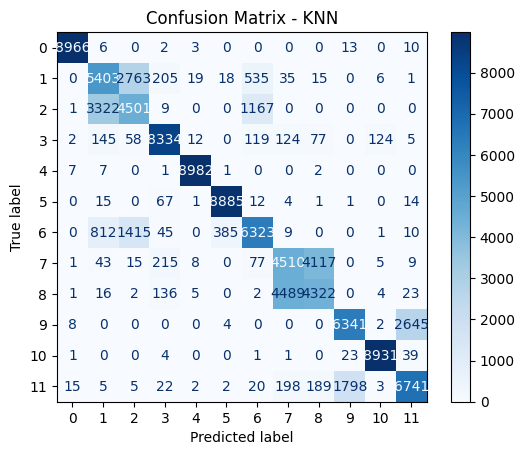

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.60      0.58      9000
           2       0.51      0.50      0.51      9000
           3       0.92      0.93      0.92      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.77      0.70      0.73      9000
           7       0.48      0.50      0.49      9000
           8       0.50      0.48      0.49      9000
           9       0.78      0.70      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.71      0.75      0.73      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [45]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_selected_scaled, y_test, name="KNN")

##### XGB

Waktu pelatihan (XGBoost): 8.1919 detik
Waktu prediksi (XGBoost): 0.2117 detik


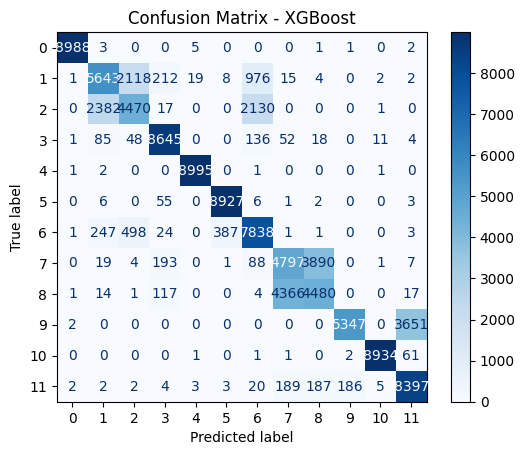

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.50      0.55      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.87      0.78      9000
           7       0.51      0.53      0.52      9000
           8       0.52      0.50      0.51      9000
           9       0.97      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [46]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist")
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

##### RF

Waktu pelatihan (Random Forest): 45.9434 detik
Waktu prediksi (Random Forest): 2.6315 detik


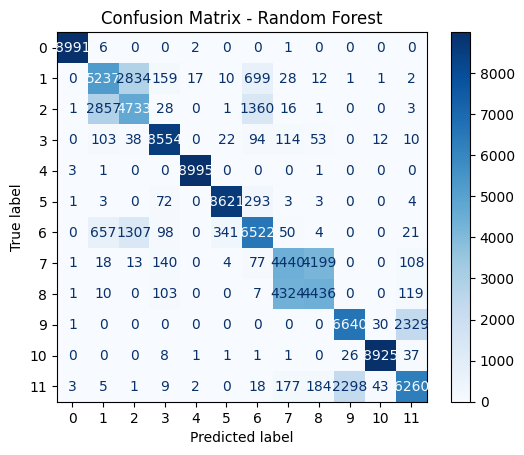

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.59      0.58      0.59      9000
           2       0.53      0.53      0.53      9000
           3       0.93      0.95      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.96      0.96      9000
           6       0.72      0.72      0.72      9000
           7       0.49      0.49      0.49      9000
           8       0.50      0.49      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.70      0.70      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [47]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test_selected_scaled, y_test, name="Random Forest")

##### NB

Waktu pelatihan (Naive Bayes): 0.2215 detik
Waktu prediksi (Naive Bayes): 0.5377 detik


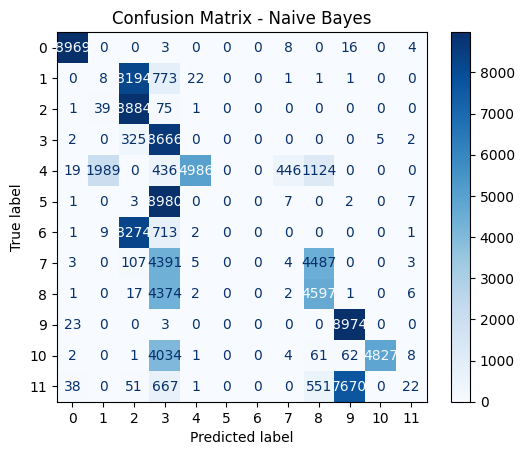

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9000
           1       0.00      0.00      0.00      9000
           2       0.34      0.99      0.51      9000
           3       0.26      0.96      0.41      9000
           4       0.99      0.55      0.71      9000
           5       0.00      0.00      0.00      9000
           6       0.00      0.00      0.00      9000
           7       0.01      0.00      0.00      9000
           8       0.42      0.51      0.46      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.42      0.00      0.00      9000

    accuracy                           0.46    108000
   macro avg       0.41      0.46      0.37    108000
weighted avg       0.41      0.46      0.37    108000



In [48]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB()
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

Waktu pelatihan (Naive Bayes): 0.2181 detik
Waktu prediksi (Naive Bayes): 0.5259 detik


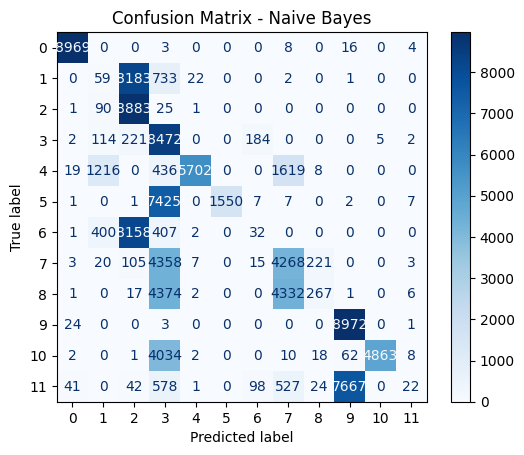

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9000
           1       0.03      0.01      0.01      9000
           2       0.35      0.99      0.51      9000
           3       0.27      0.94      0.43      9000
           4       0.99      0.63      0.77      9000
           5       1.00      0.17      0.29      9000
           6       0.10      0.00      0.01      9000
           7       0.40      0.47      0.43      9000
           8       0.50      0.03      0.06      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.42      0.00      0.00      9000

    accuracy                           0.48    108000
   macro avg       0.55      0.48      0.41    108000
weighted avg       0.55      0.48      0.41    108000



In [49]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB(var_smoothing= np.float64(1e-06))
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

##### SVM

Waktu pelatihan (SVM): 1588.2346 detik
Waktu prediksi (SVM): 1445.5666 detik


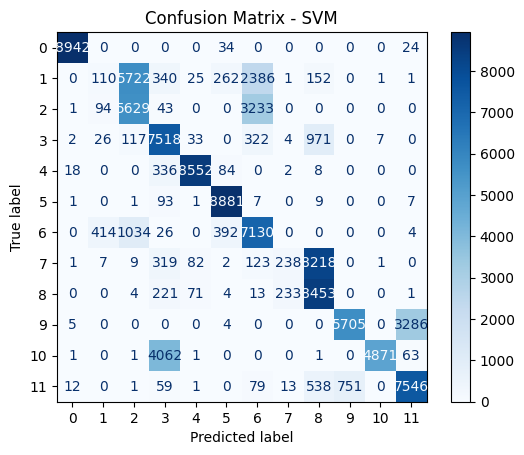

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9000
           1       0.17      0.01      0.02      9000
           2       0.45      0.63      0.52      9000
           3       0.58      0.84      0.68      9000
           4       0.98      0.95      0.96      9000
           5       0.92      0.99      0.95      9000
           6       0.54      0.79      0.64      9000
           7       0.48      0.03      0.05      9000
           8       0.46      0.94      0.62      9000
           9       0.88      0.63      0.74      9000
          10       1.00      0.54      0.70      9000
          11       0.69      0.84      0.76      9000

    accuracy                           0.68    108000
   macro avg       0.68      0.68      0.64    108000
weighted avg       0.68      0.68      0.64    108000



In [50]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")